<a href="https://colab.research.google.com/github/Nicola-Ibrahim/Pareto-Optimization/blob/main/notebooks/01_pareto_front.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric Vehicle Control Optimization

## System Definition
We model an electric vehicle (EV) traveling a fixed distance $D$, where we control its acceleration profile to optimize:
1. **Travel Time ($T$)** - Minimize total trip duration
2. **Energy Consumption ($E$)** - Minimize total energy used

## State Variables
| Variable | Symbol | Description                | Units   |
|----------|--------|----------------------------|---------|
| Position | $x(t)$ | Distance traveled          | meters (m) |
| Velocity | $v(t)$ | Current speed              | m/s     |

## Control Inputs
| Input      | Symbol | Description                | Bounds  |
|------------|--------|----------------------------|---------|
| Acceleration | $u(t)$ | Motor force command        | $[u_{min}, u_{max}]$ m/s² |

## System Dynamics
The EV's motion is governed by:

\begin{cases}
\dot{x}(t) = v(t) & \text{(Position)} \\
\dot{v}(t) = \frac{u(t)}{m} - \frac{F_{drag}(v) + F_{roll}}{m} & \text{(Velocity)} \\
F_{drag} = \frac{1}{2}\rho C_d A v^2(t) & \text{(Drag force)} \\
F_{roll} = C_r m g & \text{(Rolling resistance)}
\end{cases}

### Initial Conditions
\begin{aligned}
x(0) = 0,\ v(0) = 0
\end{aligned}

### Terminal Condition
\begin{aligned}
x(T) = D \quad \text{(Must reach target distance)}
\end{aligned}

## Optimization Problem Formulation

### Objectives
\begin{aligned}
\min_{u(t)} \mathbf{J} = \begin{bmatrix} T \\ E \end{bmatrix}
\end{aligned}

1. **Travel Time ($T$)**:
\begin{aligned}
   T = \inf \left\{ t \, \big| \, x(t) = D \right\}
   \end{aligned}
   - $D$: Total travel distance  
   - $x(t)$: Position at time $t$

2. **Energy Consumption ($E$)**:
\begin{aligned}
   E(u) = \int_0^T P\big(u(t), v(t)\big) \, dt
   \end{aligned}
   \begin{aligned}
   P(u,v) = \frac{u(t) \cdot v(t)}{\eta} + P_{\text{aux}}
   \end{aligned}
   - $\eta$: Motor efficiency (0 < $\eta$ ≤ 1)  
   - $P_{\text{aux}}$: Constant auxiliary power  
   - $u(t)$: Control input (acceleration/deceleration)  
   - $v(t)$: Velocity
   
### Constraints
1. **Control Limits**:
\begin{aligned}
u_{min} \leq u(t) \leq u_{max}
\end{aligned}

2. **Speed Limit**:
\begin{aligned}
0 \leq v(t) \leq v_{max}
\end{aligned}

3. **Distance Completion**:
\begin{aligned}
x(T) = D
\end{aligned}

## Physical Parameters
| Parameter | Symbol | Value | Description |
|-----------|--------|-------|-------------|
| Vehicle mass | $m$ | 1000 kg | - |
| Drag coefficient | $C_d$ | 0.24 | - |
| Frontal area | $A$ | 2.4 m² | - |
| Rolling coeff. | $C_r$ | 0.008 | - |
| Motor efficiency | $\eta$ | 0.85 | 85% efficient |

## Implementation Notes
- **Discretization**: The continuous control $u(t)$ is parameterized as:
  - $u_1$: Constant acceleration in Phase 1
  - $u_2$: Constant deceleration in Phase 2
- **Numerical Integration**: Trapezoidal rule used for energy calculation
- **Constraints Handling**: Normalized constraints ensure balanced optimization



In [35]:
import numpy as np
from typing import Tuple, List
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.population import Population
import matplotlib.pyplot as plt


### Simplified EVControl Problem

In [36]:
class EVControlProblem(Problem):
    """Electric Vehicle Control Optimization Problem
    Objectives: Minimize travel time and energy consumption
    Constraints: Speed limits only"""

    def __init__(self) -> None:
        # Vehicle physical parameters (all in SI units)
        self.vehicle_mass_kg: float = 1000          # Mass of the vehicle
        self.air_density_kgm3: float = 1.225        # Air density at sea level
        self.drag_coefficient: float = 0.24         # Aerodynamic drag coefficient
        self.frontal_area_m2: float = 2.4           # Vehicle frontal area
        self.rolling_coefficient: float = 0.008     # Tire rolling resistance coefficient
        self.motor_efficiency: float = 0.85         # Drivetrain efficiency (0-1)
        self.auxiliary_power_w: float = 300         # Constant power for electronics/etc
        self.max_speed_mps: float = 30              # Speed limit (≈108 km/h)
        self.target_distance_m: float = 1000        # Total trip distance

        # Bounds for acceleration/deceleration control inputs [m/s²]
        min_acceleration: float = 0.3
        max_acceleration: float = 4.0

        # Initialize problem with 2 objectives, 2 variables, and 1 constraint (speed limit)
        super().__init__(
            n_var=2,
            n_obj=2,
            n_constr=1,  # Only speed constraint
            xl=np.array([min_acceleration, min_acceleration]),
            xu=np.array([max_acceleration, max_acceleration])
        )

    def _calculate_forces(self, velocity_mps: np.ndarray) -> Tuple[np.ndarray, float]:
        """Compute aerodynamic drag and rolling resistance forces"""
        drag_force = 0.5 * self.air_density_kgm3 * self.drag_coefficient * \
                    self.frontal_area_m2 * velocity_mps**2
        rolling_force = self.rolling_coefficient * self.vehicle_mass_kg * 9.81
        return drag_force, rolling_force

    def _simulate_motion(self, a1: float, a2: float) -> Tuple[float, np.ndarray, float]:
        """Simulate vehicle motion and return key outputs"""
        # Phase 1: Acceleration
        t_accel = min(self.max_speed_mps/a1, np.sqrt(2*self.target_distance_m/a1))
        v_max = a1 * t_accel

        # Phase 2: Deceleration
        d_accel = 0.5 * a1 * t_accel**2
        remaining_d = max(0, self.target_distance_m - d_accel)
        t_decel = np.sqrt(2*remaining_d/a2) if a2 > 0 else 0

        return t_accel + t_decel, v_max

    def _calculate_energy(self, a1: float, a2: float, total_time: float) -> float:
        """Estimate energy consumption using simplified model"""
        # Simplified energy calculation (can be replaced with more accurate model)
        return (a1**2 * 0.4 + a2**2 * 0.6) * total_time / 3600  # kWh

    def _evaluate(self, control_inputs: np.ndarray, out: dict, *args, **kwargs) -> None:
        """Evaluate solutions with speed constraint only"""
        travel_times = []
        energy_consumptions = []
        speed_violations = []

        for a1, a2 in control_inputs:
            # Simulate motion (we only need total time and max velocity)
            total_time, max_velocity = self._simulate_motion(a1, a2)

            # Simplified energy calculation
            energy = self._calculate_energy(a1, a2, total_time)

            # Speed constraint violation (normalized)
            speed_violation = (max_velocity - self.max_speed_mps) / self.max_speed_mps

            travel_times.append(total_time)
            energy_consumptions.append(energy)
            speed_violations.append([speed_violation])

        out["F"] = np.column_stack([travel_times, energy_consumptions])
        out["G"] = np.array(speed_violations)

## NSGA-II Optimization Progress Metrics

### Table Column Definitions
| Column        | Description                                                                 | Interpretation                                                                 |
|---------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **`n_gen`**   | Current generation number                                                   | Tracks optimization progress (1 → N)                                           |
| **`n_eval`**  | Cumulative function evaluations                                             | Total objective function calls (time + energy calculations)                    |
| **`n_nds`**   | Non-dominated solutions in population                                       | Count of Pareto-optimal solutions found                                        |
| **`cv_min`**  | Minimum constraint violation                                                | `0.0` = feasible solution exists                                               |
| **`cv_avg`**  | Average constraint violation across population                              | Lower values → better feasibility                                              |
| **`eps`**     | Generational improvement (ε-progress)                                       | Measures movement of Pareto front                                              |
| **`indicator`**| Reference point for ε calculation                                          | Shows what drove improvement                                                   |

### Key Metric Details
#### Constraint Violations (`cv_min`, `cv_avg`)
- **`0.000000E+00`**: Perfect feasibility (all constraints satisfied)
- **Decreasing values**: Population is becoming more feasible
- **Example**: `cv_avg=0.565` → Average solution violates constraints by ~56.5%

#### Pareto Front Progress (`eps`)
| Value Range    | Interpretation                          | Example           |
|----------------|----------------------------------------|-------------------|
| **`0.01-0.1`** | Good improvement                       | `0.056` (Gen 4)  |
| **`<0.01`**    | Convergence                            | `0.001`          |
| **`-`**        | No comparison (first generation)       | Gen 1            |

#### Improvement Indicators
| Indicator  | Meaning                                                                 | When It Appears               |
|------------|-------------------------------------------------------------------------|-------------------------------|
| `ideal`    | Progress toward best possible values                                   | Early optimization (Gens 2-4) |
| `nadir`    | Progress away from worst-case values                                   | Late-stage refinement         |
| `f`        | General front movement (mixed criteria)                                | Middle phases                 |

### Your Optimization Status
1. **Feasibility Achieved**: `cv_min=0.0` since Gen 1 → Valid solutions exist  
2. **Rapid Improvement**: Large `eps` drops (0.166 → 0.056) → Effective exploration  
3. **Pareto Growth**: `n_nds` increasing (4 → 63) → Discovering more optimal solutions  
4. **Ideal-Driven**: Early `indicator=ideal` → Focusing on best potential outcomes

In [37]:
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.result import Result

# Create and solve problem

problem: EVControlProblem = EVControlProblem()


# Optimization setup with tuned operators
algorithm: NSGA2 = NSGA2(
        pop_size=200,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PolynomialMutation(prob=0.2, eta=20),
        eliminate_duplicates=True
    )

result = minimize(
    problem=problem,
    algorithm=algorithm,
    termination=('n_gen', 23),
    seed=42,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |     46 |  0.000000E+00 |  1.184238E-17 |             - |             -
     2 |      400 |     68 |  0.000000E+00 |  0.000000E+00 |  0.0057383866 |             f
     3 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.1027206962 |         nadir
     4 |      800 |    140 |  0.000000E+00 |  0.000000E+00 |  0.0083270536 |         ideal
     5 |     1000 |    186 |  0.000000E+00 |  0.000000E+00 |  0.1947367392 |         nadir
     6 |     1200 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0032136309 |         nadir
     7 |     1400 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0076396949 |         nadir
     8 |     1600 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0013887868 |             f
     9 |     1800 |    200 |  0.000000E+00 |  0.000000E+00 |  0.1015732605 |         nadir
    10 |     2000 |    200 |  0.000000E+00 |  0.000000E+00 |  0.0005990776 |             f

In [38]:
# Show first 5 pareto-solutions
print(f"Found {len(result.F)} Pareto-optimal solutions in last generation")
print(f"All non-dominated solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy) or Objective values:")
print(result.F[:5])

Found 200 Pareto-optimal solutions in last generation
All non-dominated solutions shape: (200, 2)
First 5 solutions (Time, Energy) or Objective values:
[[2.88270269e+01 1.24033613e-01]
 [8.03874565e+01 2.06502214e-03]
 [6.68765280e+01 2.88552880e-03]
 [6.67993032e+01 1.47247792e-02]
 [7.47836368e+01 2.18661143e-03]]


## 3. Pareto Front Interpretation
The optimal solutions represent trade-offs:
- **Left Extreme**: Minimum time (aggressive acceleration)
- **Right Extreme**: Minimum energy (gentle acceleration)
- **Middle**: Balanced compromises

The Pareto front $ \mathcal{X}_{\text{Pareto}} $ consists of non-dominated solutions:
\begin{aligned}
\mathcal{X}_{\text{Pareto}} = \left\{ \mathbf{J}_i = [T_i, E_i]^T \, \big| \, \nexists \, \mathbf{J}_j \text{ where } T_j \leq T_i \text{ and } E_j \leq E_i \right\}
\end{aligned}

In [39]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract non-dominated solutions
F = result.F  # Objective values (T, E)
X = result.X

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices]

print(f"Found {pareto_front.shape[1]} Pareto-optimal solutions.")


Found 200 Pareto-optimal solutions.


### Visualize problem bounds

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Design Space", "Objective Space"),
                    horizontal_spacing=0.15)

# Design Space Plot (Left)
fig.add_trace(
    go.Scatter(
        x=X[:, 0], y=X[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            line=dict(width=1, color='DarkSlateGrey')
        ),
        name='Design Points',
        hovertemplate="<b>Accel Phase 1</b>: %{x:.2f}<br><b>Accel Phase 2</b>: %{y:.2f}<extra></extra>"
    ),
    row=1, col=1
)

# Objective Space Plot (Right)
fig.add_trace(
    go.Scatter(
        x=F[:, 0], y=F[:, 1],
        mode='markers',
        marker=dict(
            size=8,
            color='blue',
            line=dict(width=1, color='DarkSlateGrey')
        ),
        name='Pareto Front',
        hovertemplate="<b>Time</b>: %{x:.2f}s<br><b>Energy</b>: %{y:.2f}kWh<extra></extra>"
    ),
    row=1, col=2
)

# Update layout for both subplots
fig.update_layout(
    title_text="EV Control Problem Analysis",
    title_x=0.5,
    showlegend=False,
    width=1000,
    height=500,
    margin=dict(l=50, r=50, b=50, t=80),
    plot_bgcolor='rgba(240,240,240,0.8)'
)

# Update x-axis and y-axis properties for Design Space
fig.update_xaxes(
    title_text="Acceleration Phase 1 (m/s²)",
    range=[xl[0], xu[0]],
    row=1, col=1,
    gridcolor='white',
    zerolinecolor='lightgrey'
)
fig.update_yaxes(
    title_text="Acceleration Phase 2 (m/s²)",
    range=[xl[1], xu[1]],
    row=1, col=1,
    gridcolor='white',
    zerolinecolor='lightgrey'
)

# Update x-axis and y-axis properties for Objective Space
fig.update_xaxes(
    title_text="Travel Time (s)",
    row=1, col=2,
    gridcolor='white',
    zerolinecolor='lightgrey'
)
fig.update_yaxes(
    title_text="Energy Consumption (kWh)",
    row=1, col=2,
    gridcolor='white',
    zerolinecolor='lightgrey'
)

# Add annotations
fig.add_annotation(
    x=0.5, y=1.1,
    xref="paper", yref="paper",
    text="Design Variables vs. Objective Space",
    showarrow=False,
    font=dict(size=14)
)

fig.show()

### Visualize the Pareto Front


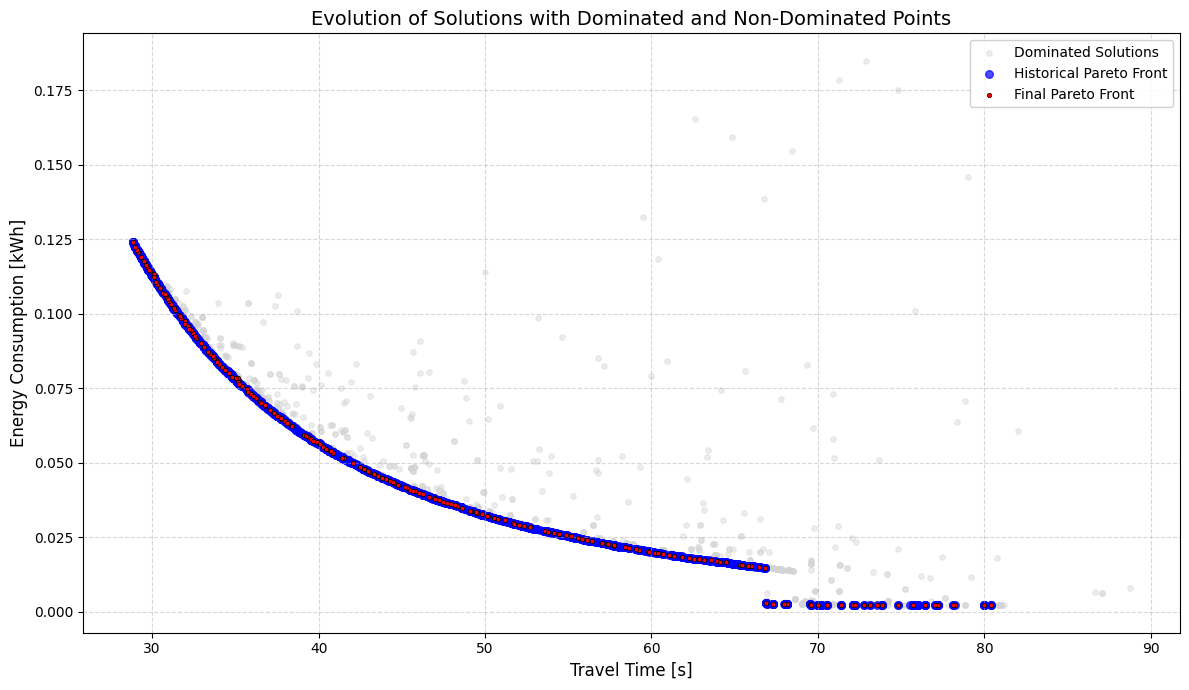

In [41]:
all_F = []
for algo in result.history:
    all_F.extend([ind.F for ind in algo.pop])
all_F = np.array(all_F)

# Identify non-dominated solutions from entire history
nds = NonDominatedSorting()
fronts = nds.do(all_F, only_non_dominated_front=False)
pareto_mask = np.zeros(len(all_F), dtype=bool)
pareto_mask[fronts[0]] = True  # First front is Pareto optimal

plt.figure(figsize=(12, 7))

# Plot dominated solutions (gray)
plt.scatter(all_F[~pareto_mask, 0], all_F[~pareto_mask, 1],
            c='lightgray', s=15, alpha=0.4, label="Dominated Solutions")

# Plot historical non-dominated solutions (blue)
plt.scatter(all_F[pareto_mask, 0], all_F[pareto_mask, 1],
            c='blue', s=30, alpha=0.7, label="Historical Pareto Front")

# Plot final optimized Pareto front (red)
if result.F.size > 0:
    plt.scatter(result.F[:, 0], result.F[:, 1],
                c='red', s=10, edgecolor='black', lw=0.5,
                label="Final Pareto Front", zorder=10)

plt.xlabel("Travel Time [s]", fontsize=12)
plt.ylabel("Energy Consumption [kWh]", fontsize=12)
plt.title("Evolution of Solutions with Dominated and Non-Dominated Points", fontsize=14)
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Results

In [42]:
import numpy as np
import pandas as pd
from pathlib import Path

root_dir = Path(__name__).parent.resolve()


def save_pareto_results(result, save_dir=root_dir / "pareto_results"):
    """Save Pareto front solutions in multiple formats for downstream use"""
    Path(save_dir).mkdir(exist_ok=True)

    # 1. Extract Pareto solutions (decision variables and objectives)
    X = result.X  # Decision variables (acceleration profiles)
    F = result.F  # Objective values (time, energy)

    # 2. Create comprehensive DataFrame
    df = pd.DataFrame(
        {
            "accel_phase1": X[:, 0],
            "accel_phase2": X[:, 1],
            "travel_time": F[:, 0],
            "energy_consumption": F[:, 1],
        }
    )

    # 3. Save in multiple formats
    # CSV - For general analysis
    df.to_csv(f"{save_dir}/pareto_data.csv", index=False)

    # NPZ - For numpy-based ML pipelines
    np.savez(f"{save_dir}/pareto_data.npz", X=X, F=F)

    print(f"Saved Pareto front ({len(F)} solutions) to {save_dir}/")


save_pareto_results(result)

Saved Pareto front (200 solutions) to /content/pareto_results/
